In [1]:
import torch
import pandas as pd
import numpy as np

# Import dataset utils
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import importlib
if importlib.util.find_spec('ipywidgets') is not None:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, Notears

import networkx as nx


2022-12-11 15:02:46,495 - /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2022-12-11 15:02:46,585 - /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


2022-12-11 15:02:54,863 - /homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


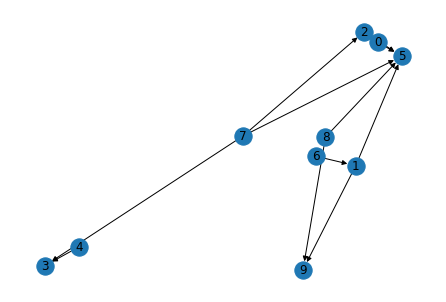

In [3]:
# data simulation, simulate true causal dag and train_data.
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=11,
                                      weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=20000, method='linear', 
                        sem_type='gauss')
true_causal_matrix, node_data = dataset.B, dataset.X

G = nx.DiGraph(true_causal_matrix)
nx.draw(G, with_labels=True)


In [4]:
# Dataset from X 
class CausalDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [5]:
# Define MLP with variable number of layers using Sequential
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        self.layers = nn.Sequential()
        self.layers.add_module('input', nn.Linear(self.input_dim, self.hidden_dim))
        self.layers.add_module('relu1', nn.ReLU())
        for i in range(self.n_layers - 1):
            self.layers.add_module('hidden' + str(i), nn.Linear(self.hidden_dim, self.hidden_dim))
            self.layers.add_module('relu' + str(i + 2), nn.ReLU())
        self.layers.add_module('output', nn.Linear(self.hidden_dim, self.output_dim))

    def forward(self, x):
        return self.layers(x)
# Train model
def train(model, train_loader, criterion, optimizer, epochs, device, verbose=True):
    model.to(device)
    model.train()
    train_loss = []
    # pbar = tqdm(range(epochs))
    for epoch in range(epochs):
        mean_epoch_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            mean_epoch_loss.append(loss.item())
        mean_epoch_loss = np.mean(mean_epoch_loss)
        # pbar.set_description(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')
        # pbar.update(1)
        train_loss.append(mean_epoch_loss)


        if verbose:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {mean_epoch_loss:.4f}')
    
    return train_loss


# Test model
def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss.append(loss.item())
    return test_loss

/homeLocal/miniconda3/envs/cml/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Training model...
Epoch 0 train loss: 3.3328428110129207 test loss: 1.179932094085506
Epoch 1 train loss: 1.1160664190728 test loss: 1.1269584498851515
Epoch 2 train loss: 1.0736195973757579 test loss: 1.0635931244263297
Epoch 3 train loss: 1.0486242275460642 test loss: 1.0667995878757106
Epoch 4 train loss: 1.039539185162649 test loss: 1.058254580911463
Epoch 5 train loss: 1.030193884644896 test loss: 1.0414488220272755
Epoch 6 train loss: 1.0303288437786398 test loss: 1.039044724705087
Epoch 7 train loss: 1.0199681858567928 test loss: 1.0474874307908726
Epoch 8 train loss: 1.0207353704574296 test loss: 1.0400738793427733
Epoch 9 train loss: 1.015044183207744 test loss: 1.0431303450948788
Epoch 10 train loss: 1.0267308733101348 test loss: 1.0408739850339863
Epoch 11 train loss: 1.0303115227383612 test loss: 1.0573459178755042
Epoch 12 train loss: 1.0118360745208546 test loss: 1.0384970686733197
Epoch 13 train loss: 1.017577848638577 test loss: 1.0288670865293477
Epoch 14 train loss: 1

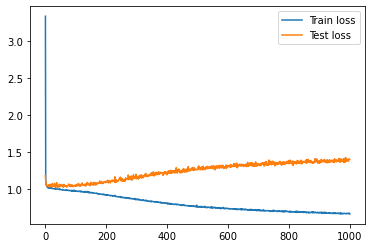

In [6]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split train and test data
causal_dataset = CausalDataset(node_data[:, :-1], node_data[:, [-1]])
train_data, test_data = train_test_split(causal_dataset, test_size=0.2, random_state=1)

# Define dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Define NN model
model = MLP(input_dim=9, hidden_dim=32, output_dim=1, n_layers=5)

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1e-2)


# Train model
print('Training model...')
full_train_loss = []
full_test_loss = []
for train_loop in range(1000):
    train_loss = train(model, train_loader, criterion, optimizer, epochs=1, device=device, verbose=False)
    test_loss = test(model, test_loader, criterion, device)
    test_loss = np.mean(test_loss)

    full_train_loss.append(train_loss[-1])
    full_test_loss.append(test_loss)

    print(f'Epoch {train_loop} train loss: {train_loss[-1]} test loss: {test_loss}')
    # Plot the results
plt.plot(full_train_loss, label='Train loss')
plt.plot(full_test_loss, label='Test loss')
plt.legend()
plt.show()


In [6]:
# Next we reimplement the network using a GCN and input the causal graph as an adjacency matrix.
# We then train the model using the same training and testing data as before.
# Use torch_geometric to build GCN

from torch_geometric.nn import GCNConv, DenseGCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeometricDataLoader
from torch_geometric.nn import Sequential as GeometricSequential
from torch_geometric.nn import models as GeometricModels

# Make a function to convert the adjacency matrix to a edje_index
# but ignore edges from the last variable to the other variables
def adj_to_edge_index(adj):
    edge_index = []
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i, j] == 1 and i != adj.shape[0] - 1:
                edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.float).t().contiguous()

# Define a Graph dataset
# here we have the full x, except it is zero on the target variable
class CausalGraphDataset(Dataset):
    def __init__(self, X, target, adj_matrix):
        self.X = torch.tensor(X, dtype=torch.double)
        self.adj_matrix = torch.tensor(adj_matrix, dtype=torch.double)
        self.edge_index = adj_to_edge_index(self.adj_matrix).long()
        self.target = target

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].clone()
        x[self.target] = 0
        x = x.unsqueeze(-1)
        return Data(x=x, edge_index=self.edge_index), self.X[idx, self.target]

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, target):
        super(GCN, self).__init__()
        self.net = GeometricModels.GCN(in_channels=input_dim, hidden_channels=hidden_dim, out_channels=output_dim, num_layers=n_layers)
        self.target = target

    def forward(self, data):
        batch_size = data.batch[-1].item() + 1
        x = data.x
        edge_index = data.edge_index
        y_hat = self.net(x, edge_index)

        reshaped_y_hat = y_hat.reshape(batch_size, -1)
        return reshaped_y_hat[:, self.target]


In [7]:
batch_size = 128
device = torch.device("cpu")
target = [5, 9]

structural_dataset = CausalGraphDataset(node_data, target, true_causal_matrix)
train_structural_data, test_structural_data = train_test_split(structural_dataset, test_size=0.2, random_state=1)

train_structural_dataloader = GeometricDataLoader(train_structural_data, batch_size=batch_size, shuffle=True)
test_structural_dataloader = GeometricDataLoader(test_structural_data, batch_size=batch_size, shuffle=True)

# Define NN model
gcn_model = GCN(input_dim=1, hidden_dim=32, output_dim=1, n_layers=5, target=target)

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.1e-2)

# Train model
print('Training model...')
full_train_loss = []
full_test_loss = []
for train_loop in range(1000):

    if train_loop % 100 == 0:
        # adjust learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1

    train_loss = train(gcn_model, train_structural_dataloader, criterion, optimizer, epochs=1, device=device, verbose=False)
    test_loss = test(gcn_model, test_structural_dataloader, criterion, device)
    test_loss = np.mean(test_loss)

    full_train_loss.append(train_loss[-1])
    full_test_loss.append(test_loss)

    print(f'Epoch {train_loop} train loss: {train_loss[-1]} test loss: {test_loss}')
    # Plot the results
plt.plot(full_train_loss, label='Train loss')
plt.plot(full_test_loss, label='Test loss')
plt.legend()
plt.show()




Training model...
Epoch 0 train loss: 11.738382193539058 test loss: 11.879551183254156
Epoch 1 train loss: 11.54572376977292 test loss: 11.713179472300993
Epoch 2 train loss: 11.231620400655233 test loss: 11.16705036660549
Epoch 3 train loss: 10.422016613429474 test loss: 10.165078368802229
Epoch 4 train loss: 9.543641762687027 test loss: 9.474194992649544
Epoch 5 train loss: 8.88291332215957 test loss: 8.77343418276358
Epoch 6 train loss: 8.304362939118878 test loss: 8.230881993137382
Epoch 7 train loss: 7.8026792690245195 test loss: 7.663290269500456
Epoch 8 train loss: 7.554392447367724 test loss: 7.473244002081511
Epoch 9 train loss: 7.220502850160584 test loss: 7.1925004119871625
Epoch 10 train loss: 6.9949892878822295 test loss: 7.083596571821572
Epoch 11 train loss: 6.854968455911263 test loss: 7.008241602060016
Epoch 12 train loss: 6.789390945930925 test loss: 7.107433196572394
Epoch 13 train loss: 6.674581198644881 test loss: 7.286951902445931
Epoch 14 train loss: 6.5930265982

In [7]:
# Save model and weights
torch.save(gcn_model.state_dict(), 'gcn_model.pth')

NameError: name 'gcn_model' is not defined